#### 200119C

# Question 1

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'


Parameters of Largest Circle:
Radius: 72.40773439350254
Center Coordinates as (x, y): (98, 884)

Range of σ values used:
Minimum σ: 0.4
Maximum σ: 51.200000000000045



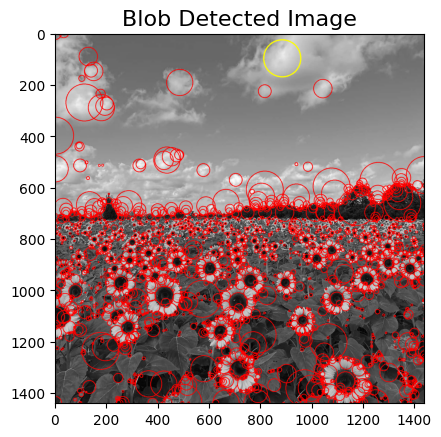

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Function to generate LoG kernel
def generate_log_kernel(sigma, size):
    if size % 2 == 0:
        size = size + 1

    sigma2 = sigma ** 2
    idx_range = np.linspace(-(size - 1) / 2., (size - 1) / 2., size)
    x_idx, y_idx = np.meshgrid(idx_range, idx_range)
    tmp_cal = -(np.square(x_idx) + np.square(y_idx)) / (2. * sigma2)
    kernel = np.exp(tmp_cal)
    kernel[kernel < np.finfo(float).eps * np.amax(kernel)] = 0
    k_sum = np.sum(kernel)

    if k_sum != 0:
        kernel /= np.sum(kernel)

    tmp_kernel = np.multiply(kernel, np.square(x_idx) + np.square(y_idx) - 2 * sigma2) / (sigma2 ** 2)
    kernel = tmp_kernel - np.sum(tmp_kernel) / (size ** 2)
    return kernel

# Function to display the kernel
def display_kernel(kernel):
    plt.imshow(kernel, cmap='viridis')
    plt.colorbar()
    plt.title('Kernel')
    plt.show()

# Load the input image
image = cv.imread(r"/content/drive/MyDrive/IMAGE PROCESSING AND MACHINE VISION/the_berry_farms_sunflower_field.jpeg")

# Convert image to grayscale
gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
gray_image = np.float32(gray_image)
cv.normalize(gray_image, gray_image, 1, 0, cv.NORM_MINMAX)

# Parameters for LoG filtering
initial_sigma = 0.4
scale_factor = np.sqrt(2)
num_scales = 15
sigmas = initial_sigma * np.power(scale_factor, np.arange(num_scales))

# LoG Filtering at Multiple Scales
image_stack = None
for i in range(num_scales):
    size = int(2 * np.ceil(4 * sigmas[i]) + 1)
    kernel = generate_log_kernel(sigmas[i], size) * np.power(sigmas[i], 2)
    filtered_image = cv.filter2D(gray_image, cv.CV_32F, kernel)
    filtered_image = pow(filtered_image, 2)
    if i == 0:
        image_stack = filtered_image
    else:
        image_stack = np.dstack((image_stack, filtered_image))

# Maximum Response Extraction
scale_space = None
for i in range(num_scales):
    dilated_image = cv.dilate(image_stack[:, :, i], np.ones((3, 3)), cv.CV_32F, (-1, -1), 1, cv.BORDER_CONSTANT)
    if i == 0:
        scale_space = dilated_image
    else:
        scale_space = np.dstack((scale_space, dilated_image))

max_response_stack = np.amax(scale_space, axis=2)
max_response_stack = np.repeat(max_response_stack[:, :, np.newaxis], num_scales, axis=2)
max_response_stack = np.multiply((max_response_stack == scale_space), scale_space)

# Extract blob parameters
radius_vector = None
x_coordinate_vector = None
y_coordinate_vector = None
for i in range(num_scales):
    radius = np.sqrt(2) * sigmas[i]
    threshold = 0.01
    valid_responses = (max_response_stack[:, :, i] == image_stack[:, :, i]) * image_stack[:, :, i]
    valid_responses[valid_responses <= threshold] = 0
    (x, y) = np.nonzero(valid_responses)
    if i == 1:
        x_coordinate_vector = x
        y_coordinate_vector = y
        radius_vector = np.repeat(radius, np.size(x))
    else:
        x_coordinate_vector = np.concatenate((x_coordinate_vector, x), axis=None)
        y_coordinate_vector = np.concatenate((y_coordinate_vector, y), axis=None)
        tmp_radius_vector = np.repeat(radius, np.size(x))
        radius_vector = np.concatenate((radius_vector, tmp_radius_vector), axis=None)

# Find the parameters of the largest circles
max_radius = np.max(radius_vector)
max_circle_index = np.argmax(radius_vector)
max_x_coordinate = x_coordinate_vector[max_circle_index]
max_y_coordinate = y_coordinate_vector[max_circle_index]

# Report the parameters of the largest circles
print()
print(f"Parameters of Largest Circle:")
print(f"Radius: {max_radius}")
print(f"Center Coordinates as (x, y): ({max_x_coordinate}, {max_y_coordinate})")
min_sigma_value = np.min(sigmas)
max_sigma_value = np.max(sigmas)
print(f"\nRange of σ values used:")
print(f"Minimum σ: {min_sigma_value}")
print(f"Maximum σ: {max_sigma_value}")
print()

# Highlight the detected circles in the output image
output_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
output_image = cv.cvtColor(output_image, cv.COLOR_GRAY2BGR)

for i in range(np.size(x_coordinate_vector)):
    if i == max_circle_index:
        cv.circle(output_image, (y_coordinate_vector[i], x_coordinate_vector[i]), int(radius_vector[i]), (0,255,255), 3) # Largest circle in yellow
    else:
        cv.circle(output_image, (y_coordinate_vector[i], x_coordinate_vector[i]), int(radius_vector[i]), (0, 0, 255), 2) # Other circles in red

# Save the output image
cv.imwrite("../Outputs/" + image_name + "_blob_detected_COLOUR.jpeg", output_image)

# Display the output image
plt.imshow(cv.cvtColor(output_image, cv.COLOR_BGR2RGB))
plt.title("Blob Detected Image", fontsize=16)
plt.show()


## Question 02

In [ ]:
pip install tikzplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/54.2 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 2.1 MB/s eta 0:00:00


--------------------------------------implementing RANSAC Line---------------------------------

iteration 24
line_best_error 11.090554268662725
best_line_indices [51 94]
best_line_model [0.70627697 0.70793562 1.48451973]
no of inliers 41

--------------------------------------implementing RANSAC Circle---------------------------------

Number of Elements in X: 100
Number of Line Inliers: 41
Remnants: 59

iteration 1
best_error 9.023742812473422
best_indices [41 22  0]
best_model [2.21037321 2.93410845 9.91111445]
no of inliers 41

iteration 5
best_error 6.004641595939938
best_indices [39 21 25]
best_model [1.74620696 2.56686169 9.97811905]
no of inliers 40


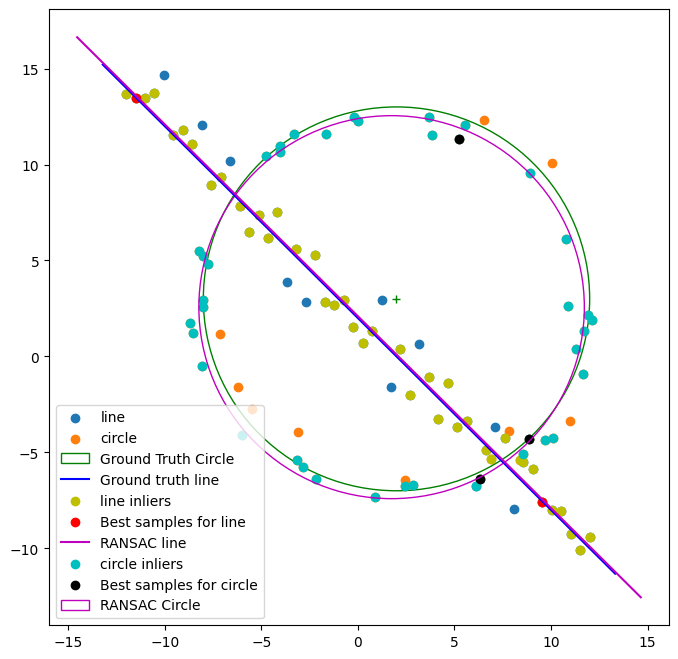

In [ ]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Generating a Noisy Point Set Conforming to a Line and a Circle
N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3
s = r / 16

# Generating points for the circle
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

# Generating points for the line
s = 1.
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

# Combining points from the circle and the line
X = np.vstack((X_circ, X_line))

# Plotting the generated points
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='circle')
circle_get = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground Truth Circle')
ax.add_patch(circle_get)
ax.plot((x0_gt), (y0_gt), '+', color='g')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='b', label='Ground truth line')
plt.legend()

# RANSAC Line Fitting
N = X.shape[0]
print('--------------------------------------implementing RANSAC Line---------------------------------')

# Total least square error for line
def line_total_error(x, line_indices):
    a, b, d = x[0], x[1], x[2]
    return np.sum(np.square(a * X[line_indices, 0] + b * X[line_indices, 1] - d))

# Constraint function for the circle
def cons(x):
    return x[0]**2 + x[1]**2 - 1

constraint = ({'type': 'eq', 'fun': cons})

# Consensus set calculation for the line
def line_consensus_set(X, x, line_threshold):
    a, b, d = x[0], x[1], x[2]
    error = np.abs(a * X[:, 0] + b * X[:, 1] - d)
    return error < line_threshold

line_max_iteration = 100
line_threshold = 1.
line_data_points = 0.4 * N
line_best_error = np.inf
line_sample = 2

best_line_indices = []
best_line_model = []
line_inliners = []
best_line_inliers = []
line_iteration = 0

while line_iteration < line_max_iteration:
    line_indices = np.random.randint(0, N, line_sample)
    x0 = np.array([1, 1, 0])
    res = minimize(line_total_error, x0=x0, args=(line_indices), tol=1e-6, constraints=constraint)
    line_inliners = line_consensus_set(X, res.x, line_threshold)
    if np.sum(line_inliners) > line_data_points:
        x0 = res.x
        res = minimize(line_total_error, x0=x0, args=(line_inliners), tol=1e-6, constraints=constraint)
        if res.fun < line_best_error:
            print('\niteration', line_iteration)
            line_best_error = res.fun
            best_line_indices = line_indices
            best_line_model = res.x
            best_line_inliers = line_inliners
            print('line_best_error', line_best_error)
            print('best_line_indices', best_line_indices)
            print('best_line_model', best_line_model)
            print('no of inliers', np.sum(best_line_inliers))
    line_iteration += 1

ax.scatter(X[best_line_inliers, 0], X[best_line_inliers, 1], color='y', label='line inliers')
ax.scatter(X[best_line_indices, 0], X[best_line_indices, 1], color='r', label='Best samples for line')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_line_model[1] * x_ + best_line_model[2]) / best_line_model[1]
plt.plot(x_, y_, color='m', label='RANSAC line')
ax.legend()

# RANSAC Circle Fitting
print('\n--------------------------------------implementing RANSAC Circle---------------------------------\n')
print('Number of Elements in X:', len(X))
print('Number of Line Inliers:', np.sum(best_line_inliers))

line_outliers = np.where(best_line_inliers == False)[0]
remnants = np.array([X[line_outliers[i]] for i in range(len(line_outliers))])
print('Remnants:', len(remnants))

# Total least square error for circle
def circle_tls(x, indices):
    x0, y0, r = x
    x1, y1 = remnants[indices].T
    return np.sum((np.sqrt((x1 - x0)**2 + (y1 - y0)**2) - r)**2)

# Consensus set calculation for the circle
def circle_consensus_set(remnants, x, circle_threshold):
    distances = np.abs(np.linalg.norm(remnants - x[:2], axis=1) - x[2])
    return distances < circle_threshold

circle_threshold = 1.
max_circle_iterations = 100
circle_best_model = []
circle_best_inliers = []
circle_best_error = np.inf
circle_best_indices = []
circle_iteration = 0
circle_sample = 3
circle_num_data = 35

while circle_iteration < max_circle_iterations:
    circle_indices = np.random.randint(0, len(remnants), circle_sample)
    x0 = np.array([0, 0, 0])
    res = minimize(circle_tls, x0, args=circle_indices, tol=1e-6)
    circle_inliers = circle_consensus_set(remnants, res.x, circle_threshold)
    if np.sum(circle_inliers) > circle_num_data:
        x0 = res.x
        res = minimize(circle_tls, x0=x0, args=(circle_inliers), tol=1e-6)
        if res.fun < circle_best_error:
            print('\niteration', circle_iteration)
            circle_best_error = res.fun
            circle_best_indices = circle_indices
            circle_best_model = res.x
            circle_best_inliers = circle_inliers
            print('best_error', circle_best_error)
            print('best_indices', circle_best_indices)
            print('best_model', circle_best_model)
            print('no of inliers', np.sum(circle_best_inliers))
    circle_iteration += 1

ax.scatter(remnants[circle_best_inliers, 0], remnants[circle_best_inliers, 1], color='c', label='circle inliers')
ax.scatter(remnants[circle_best_indices, 0], remnants[circle_best_indices, 1], color='k', label='Best samples for circle')
circle = plt.Circle((circle_best_model[0], circle_best_model[1]), circle_best_model[2], color='m', fill=False, label='RANSAC Circle')
ax.add_patch(circle)
ax.legend()

plt.show()


## Question 03

In [4]:
!pip install opencv-python-headless
!pip install numpy
!pip install matplotlib
!pip install scipy


  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached numpy-2.1.2-cp311-cp311-win_amd64.whl.metadata (59 kB)
Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl (38.8 MB)
Using cached numpy-2.1.2-cp311-cp311-win_amd64.whl (12.9 MB)



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached matplotlib-3.9.2-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.0-cp311-cp311-win_amd64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.54.1-cp311-cp311-win_amd64.whl.metadata (167 kB)
  Using cached kiwisolver-1.4.7-cp311-cp311-win_amd64.whl.metadata (6.4 kB)
  Using cached pillow-11.0.0-cp311-cp311-win_amd64.whl.metadata (9.3 kB)
  Using cached pyparsing-3.2.0-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.9.2-cp311-cp311-win_amd64.whl (7.8 MB)
Using cached contourpy-1.3.0-cp311-cp311-win_amd64.whl (217 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.54.1-cp311-cp311-win_amd64.whl (2.2 MB)
Using cached kiwisolver-1.4.7-cp311-cp311-win_amd64.whl (56 kB)
Using cached pillow-11.0.0-cp311-cp311-win_amd64.whl (2.6 MB)
Using cached pyparsing-3.2.0-py3-none-any.whl (106 kB)



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



  Using cached scipy-1.14.1-cp311-cp311-win_amd64.whl.metadata (60 kB)
Using cached scipy-1.14.1-cp311-cp311-win_amd64.whl (44.8 MB)


In [ ]:
import cv2 
import numpy as np

matplotlib.use('agg')
import matplotlib
  # or choose another backend like 'tkagg', 'qt5agg', etc.

import matplotlib.pyplot as plt


SyntaxError: invalid syntax (2836115429.py, line 4)

In [5]:


# Initialize a list to store the selected points
selected_points = []

# Callback function for mouse click events
def mouse_click(event, x, y, flags, param):
    global selected_points

    if event == cv2.EVENT_LBUTTONDOWN:
        selected_points.append((x, y))
        cv2.circle(architectural_image, (x, y), 4, (0, 0, 255), -1)
        cv2.imshow('Image', architectural_image)




architectural_image = cv2.imread(r'images/005.jpg')
flag = cv2.imread(r'images/flag.png')

architectural_image = architectural_image.astype(np.float32) / np.iinfo(architectural_image.dtype).max
flag = flag.astype(np.float32) / np.iinfo(flag.dtype).max

print("Image shape:", architectural_image.shape)
print("Flag shape:", flag.shape)

cv2.imshow('Image', architectural_image)
cv2.setMouseCallback('Image', mouse_click)

# Wait for the user to select four points
while len(selected_points) < 4:
    cv2.waitKey(1)

cv2.destroyAllWindows()

print("Selected Points:", selected_points)

dst_points = np.array(selected_points).astype(np.float32)
h2, w2 = flag.shape[:2]
src_points = np.float32([[0, 0], [w2, 0], [0, h2], [w2, h2]])

H = cv2.getPerspectiveTransform( src_points,dst_points) #homograph matrix
print('Homograph matrix\n',H)

flag_warped = cv2.warpPerspective(flag, H, (architectural_image.shape[1], architectural_image.shape[0]))
superimposed_image = cv.addWeighted(architectural_image, 1, flag_warped, 0.5, 0)


plt.subplot(2, 2, 1)
plt.imshow(cv.cvtColor(architectural_image, cv.COLOR_BGR2RGB))
plt.title('Architectural Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(cv.cvtColor(flag, cv.COLOR_BGR2RGB))
plt.title('Flag')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(flag_warped)
plt.title('Warped Flag')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(cv.cvtColor(superimposed_image, cv.COLOR_BGR2RGB))
plt.title('Superimposed Image')
plt.axis('off')




Image shape: (768, 1024, 3)
Flag shape: (960, 1920, 3)


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1301: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


# Question 04

In [ ]:
import cv2  as cv
import numpy as np
import matplotlib.pyplot as plt


((< cv2.DMatch 0x7864ebd07fb0>, < cv2.DMatch 0x7864ebc1fd10>), (< cv2.DMatch 0x7864ebc1fd30>, < cv2.DMatch 0x7864ebc1fd50>), (< cv2.DMatch 0x7864ebc1fd70>, < cv2.DMatch 0x7864ebc1ea90>), (< cv2.DMatch 0x7864ebc1f830>, < cv2.DMatch 0x7864ebc1eab0>), (< cv2.DMatch 0x7864ebc1f730>, < cv2.DMatch 0x7864ebc1fb90>))


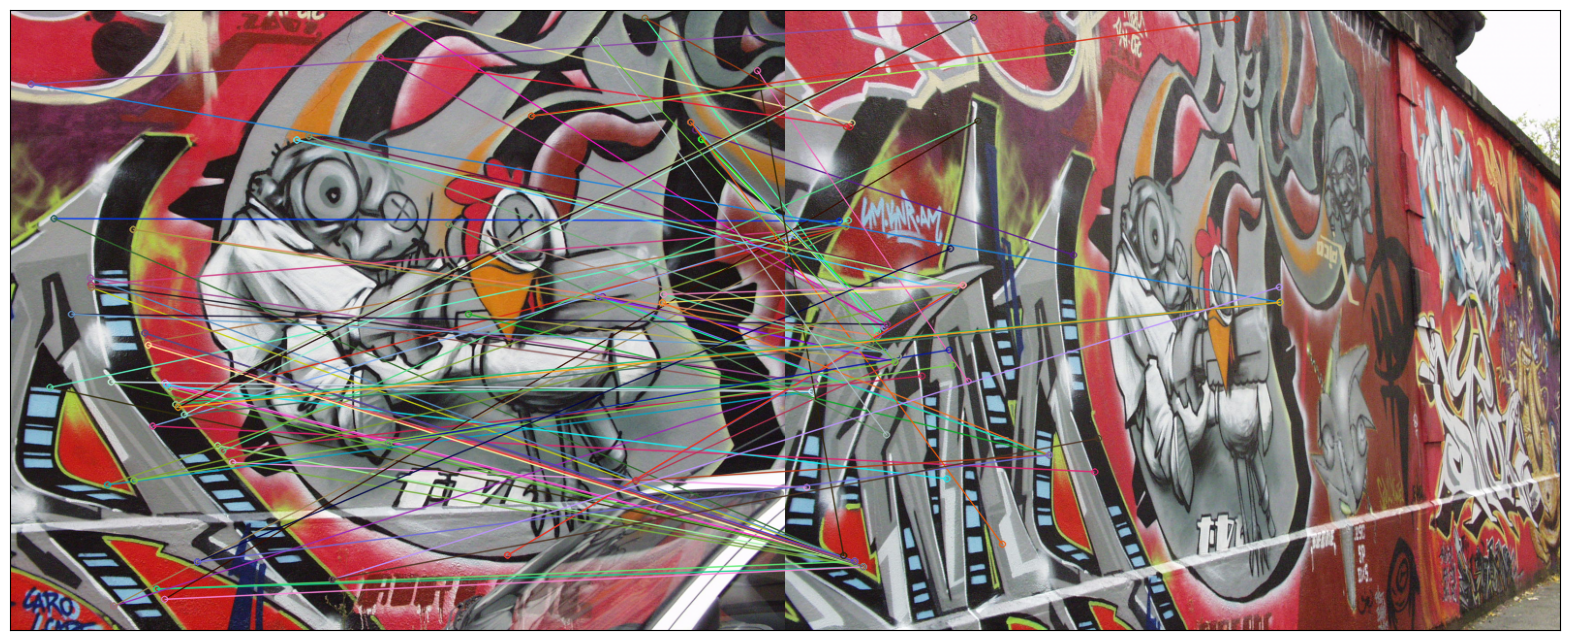

In [ ]:
img1 = cv.imread(r'/content/drive/MyDrive/IMAGE PROCESSING AND MACHINE VISION/graf/img1.ppm')
img5 = cv.imread(r'/content/drive/MyDrive/IMAGE PROCESSING AND MACHINE VISION/graf/img5.ppm')
h_text = open('/content/drive/MyDrive/IMAGE PROCESSING AND MACHINE VISION/graf/H1to5p','r')

img1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
img5_gray = cv.cvtColor(img5, cv.COLOR_BGR2GRAY)
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img5 = cv.cvtColor(img5, cv.COLOR_BGR2RGB)

sift = cv.SIFT_create()
bf = cv.BFMatcher()

key1, des1 = sift.detectAndCompute(img1_gray, None)
key5, des5 = sift.detectAndCompute(img5_gray, None)

matches = bf.knnMatch(des1, des5, k=2)
print(matches[:5])
matches = sorted(matches, key=lambda x:x[0].distance)

out_img = cv.drawMatchesKnn(img1, key1, img5, key5, matches[:50], img5, flags=2) #only draw bets 50 matches

fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(out_img)
ax.set_xticks([])
ax.set_yticks([])

plt.show()

In [ ]:
def findFeatures(img):
    sift = cv.SIFT_create()
    key, des = sift.detectAndCompute(img, None)
    return key, des

def findMatches(des1, des5):
    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1, des5, k=2)
    return matches


def calHomography(sample):
    A = []
    for i in range(len(sample)):
        x1, y1, x2, y2 = sample[i, 0], sample[i, 1], sample[i, 2], sample[i, 3]
        A.append([-x1, -y1, -1, 0, 0, 0, x2*x1, x2*y1, x2])
        A.append([0, 0, 0, -x1, -y1, -1, y2*x1, y2*y1, y2])

    A = np.matrix(A)
    U, S, V = np.linalg.svd(A)
    H = np.reshape(V[-1], (3, 3))
    H = (1/H.item(8))*H
    return H

def calDistance(H, correspondence):
    p1 = np.transpose(np.matrix([correspondence[0].item(0), correspondence[0].item(1), 1]))
    estimatep2 = np.dot(H, p1)
    estimatep2 = (1/estimatep2.item(2))*estimatep2

    p2 = np.transpose(np.matrix([correspondence[0].item(2), correspondence[0].item(3), 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)


def RANSAC(corres,threshold):
    max_inliers = []
    homography = []

    for i in range(int(np.log(1 - 0.95)/np.log(1 - (1 - 0.5)**4))):
        corr1 = corres[np.random.randint(0, len(corres))]
        corr2 = corres[np.random.randint(0, len(corres))]
        sample = np.vstack((corr1, corr2))
        corr3 = corres[np.random.randint(0, len(corres))]
        sample = np.vstack((sample, corr3))
        corr4 = corres[np.random.randint(0, len(corres))]
        sample = np.vstack((sample, corr4))


        h = calHomography(sample)
        inliers = []

        for j in range(len(corres)):
            distance = calDistance(h, corres[j])
            if distance < threshold:
                inliers.append(corres[j])


        if len(inliers) > len(max_inliers):
            max_inliers = inliers

            homography = h

    return homography,inliers

In [ ]:
estimated_threshold = 100

correspondence = []
key1, des1 = findFeatures(img1)
key5, des5 = findFeatures(img5)
keypoints = [key1, key5]
matches = findMatches(des1, des5)

for match in matches:
    (x1, y1) = keypoints[0][match[0].queryIdx].pt
    (x2, y2) = keypoints[1][match[0].trainIdx].pt
    correspondence.append([x1, y1, x2, y2])

corres = np.matrix(correspondence)
H,inliers =RANSAC(corres,estimated_threshold)
print(H)

print('no of inliers',len(inliers))

[[-1.37191979e-01 -1.65814648e-01  1.47534441e+02]
 [-3.38858722e-01 -3.60161357e-01  3.49200840e+02]
 [-9.65496344e-04 -1.04868854e-03  1.00000000e+00]]
no of inliers 186


(640, 800, 3)
(640, 800, 3)


(-0.5, 799.5, 639.5, -0.5)

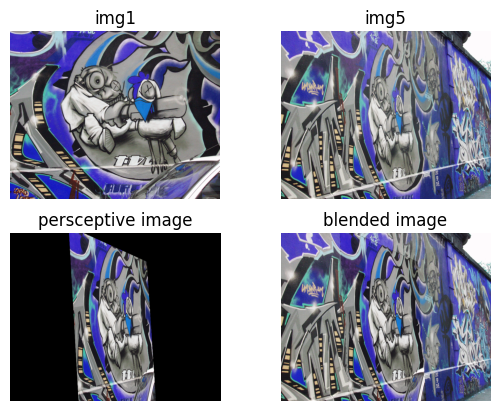

In [ ]:
plt.subplot(2,2,1)
plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
plt.title('img1')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(cv.cvtColor(img5, cv.COLOR_BGR2RGB))
plt.title('img5')
plt.axis('off')
print(img1.shape)
print(img5.shape)


#coverting h_text to homography matrix
original_H = []
for line in h_text:
    line = line.strip()
    line = line.split()
    line = [float(i) for i in line]
    original_H.append(line)


original_H = np.matrix(original_H)

image_perspective = cv.warpPerspective(img1, original_H, (img5.shape[1], img5.shape[0]))
plt.subplot(2,2,3)
plt.imshow(cv.cvtColor(image_perspective, cv.COLOR_BGR2RGB))
plt.title('persceptive image')
plt.axis('off')

threshold, mask = cv.threshold(cv.cvtColor(image_perspective, cv.COLOR_BGR2GRAY), 1, 255, cv.THRESH_BINARY)
mask_inv = cv.bitwise_not(mask)
img5_bg = cv.bitwise_and(img5, img5, mask=mask_inv)
dst = cv.addWeighted(img5_bg, 1, image_perspective, 1, 0)
#dst = cv.add(image_perspective, img5_bg)
plt.subplot(2,2,4)
plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB))
plt.title('blended image')
plt.axis('off')
